In [1]:
%load_ext lab_black

In [2]:
# Loading all necessary libraries
import numpy as np
import pandas as pd
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from dateutil import parser
from collections import defaultdict
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re
import spacy
import matplotlib.pyplot as plt
import random
import unidecode
import emoji
import json
import gc

%matplotlib inline

sp = spacy.load("it_core_news_lg")

In [3]:
TYPE_PAGE_LIST = ["news", "politicians"]
TYPE_SOCIAL_LIST = ["facebook"] #["facebook", "instagram"]
COUNTRY_PAGE_LIST = ["italy"]

DATA_PATH = "Data/"

COLUMNS_TYPES_FB = {}
COLUMNS_TYPES_IG = {}

## Read Data

In [4]:
df_map = {}
df_covid_phase_map = {
    "pre_covid": {},
    "during_covid": {},
    "post_covid": {},
}

In [5]:
for type_page in TYPE_PAGE_LIST:
    for type_social in TYPE_SOCIAL_LIST:
        for country_page in COUNTRY_PAGE_LIST:
            name_df = "_".join((type_page, type_social, country_page))
            df_map[name_df] = pd.read_csv(DATA_PATH + name_df + ".csv", header=0,)
            df_map[name_df]["Created"] = df_map[name_df]["Created"].apply(
                lambda x: parser.parse(x)
            )
            if type_social == "instagram":
                df_map[name_df]["Description"] = df_map[name_df]["Description"].fillna(
                    value=""
                )
            else:
                df_map[name_df]["Message"] = df_map[name_df]["Message"].fillna(value="")

/Users/silvio/opt/anaconda3/envs/ricerca/lib/python3.7/site-packages/dateutil/parser/_parser.py:1218: UnknownTimezoneWarning: tzname EDT identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  category=UnknownTimezoneWarning)
/Users/silvio/opt/anaconda3/envs/ricerca/lib/python3.7/site-packages/dateutil/parser/_parser.py:1218: UnknownTimezoneWarning: tzname EST identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  category=UnknownTimezoneWarning)


In [6]:
# df_map["politicians_facebook_italy"].head()

### Create DFs Map per Covid Phase (Pre-Covid = 12/2019 - 03/2020 , During-Covid = 03/2020 - 05/2020, Post-Covid = 05/2020 - 08/2020)

In [7]:
for name_df, df in df_map.items():
    df_covid_phase_map["pre_covid"][name_df] = df_map[name_df][
        (df_map[name_df]["Created"] >= "2019-12-01")
        & (df_map[name_df]["Created"] < "2020-03-01")
    ].copy()

    df_covid_phase_map["during_covid"][name_df] = df_map[name_df][
        (df_map[name_df]["Created"] >= "2020-03-01")
        & (df_map[name_df]["Created"] < "2020-05-18")
    ].copy()

    df_covid_phase_map["post_covid"][name_df] = df_map[name_df][
        (df_map[name_df]["Created"] >= "2020-05-18")
        & (df_map[name_df]["Created"] < "2020-08-13")
    ].copy()

In [8]:
del df_map
gc.collect()

2535

### Creating Text Blocks

In [9]:
all_stopwords = sp.Defaults.stop_words
with open("stopwords_italian.json") as json_file:
    italian_stopwords = json.load(json_file)
all_stopwords |= set(italian_stopwords["stopwords"])

In [10]:
def remove_emoji(text):
    return emoji.get_emoji_regexp().sub(u"", text)

In [11]:
def grey_color_func(
    word, font_size, position, orientation, random_state=None, **kwargs
):
    return "hsl(0, 0%%, %d%%)" % random.randint(60, 100)

In [12]:
phases_text_blocks = defaultdict(str)

In [13]:
def clean_text(text):
    text = remove_emoji(text)
    # text = unidecode.unidecode(text)
    text = text.lower()
    text = text.strip()
    text = re.sub("#\S+:", "", text)
    text = re.sub("# \S+ :", "", text)
    text = re.sub(r"legaonline.it\S+", "", text)
    text = re.sub("[,\.!?]", "", text)
    text = re.sub(r"@\w+", "@USER ", text)
    text = re.sub(r"http\S+", "_URL_ ", text)
    for _ in range(5):
        text = re.sub(r"\s+", " ", text)
    text = (
        text.replace("http", "")
        .replace("www", "")
        .replace("shortener", "")
        .replace("ref", "")
        .replace("matteo salvini", "salvini")
        .replace("user", "")
        .replace("legaonline.it/iostoconsalvini", "")
    )
    text = text.lower()
    # stop_words = set(stopwords.words("italian"))
    text_tokens = word_tokenize(text)
    tokens_without_sw = [word for word in text_tokens if not word in all_stopwords]

    res = " ".join(tokens_without_sw)
    return res

In [14]:
for phase, dicts in df_covid_phase_map.items():
    for name, df in dicts.items():
        if name.split("_")[0] == "politicians":
            if name.split("_")[1] == "instagram":
                df["Description"] = df["Description"].apply(lambda x: clean_text(x))
                phases_text_blocks[phase] += " ".join(list(df["Description"].values))
            else:
                # facebook
                df["Message"] = df["Message"].apply(lambda x: clean_text(x))
                phases_text_blocks[phase] += " ".join(list(df["Message"].values))

In [15]:
# phases_text_blocks = {
#   phase: clean_text(text) for phase, text in phases_text_blocks.items()
# }

In [16]:
# with open("temp.txt", "w") as writer:
#    writer.write(phases_text_blocks["post_covid"])

### Create and generate wordclouds:

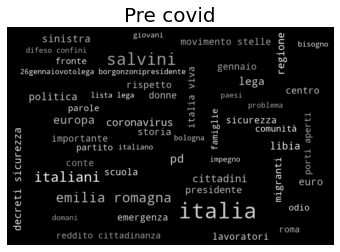

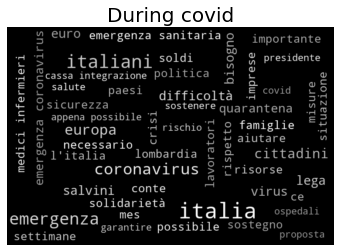

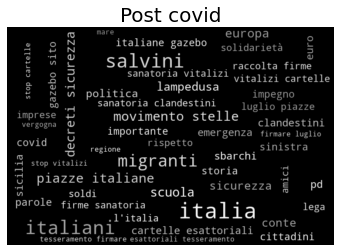

In [17]:
for p, text_ in phases_text_blocks.items():
    wordcloud = WordCloud(
        max_font_size=50,
        max_words=50,
        # background_color="darkblue",
        # colormap="Blues",
        min_font_size=10,
        margin=10,
        random_state=1,
        width=750,
        height=500,
    ).generate(text_)
    default_colors = wordcloud.to_array()
    plt.figure()
    plt.title(p.replace("_", " ").capitalize(), fontsize=20)
    plt.imshow(
        wordcloud.recolor(color_func=grey_color_func, random_state=3),
        interpolation="bilinear",
    )
    # plt.imshow(wordcloud, interpolation="bilinear", aspect="auto")
    plt.axis("off")
    plt.savefig("Output/wordclouds/" + p + ".png", dpi=300)
    plt.show()

## LDA Analysis

In [18]:
# Load the library with the CountVectorizer method
from sklearn.feature_extraction.text import CountVectorizer
import seaborn as sns

sns.set_style("whitegrid")
# Helper function
def plot_10_most_common_words(count_data, count_vectorizer, phase, name):
    words = count_vectorizer.get_feature_names()
    total_counts = np.zeros(len(words))
    for t in count_data:
        # print(t)
        total_counts += t.toarray()[0]

    count_dict = zip(words, total_counts)
    count_dict = sorted(count_dict, key=lambda x: x[1], reverse=True)[0:10]
    words = [w[0] for w in count_dict]
    counts = [w[1] for w in count_dict]
    x_pos = np.arange(len(words))

    plt.figure(2, figsize=(15, 15 / 1.6180))
    plt.subplot(
        title="10 most common words - {} - {}".format(
            phase.replace("_", " ").capitalize(), name.replace("_", " ").capitalize()
        )
    )
    sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 2.5})
    sns.barplot(x_pos, counts, palette="husl")
    plt.xticks(x_pos, words, rotation=90)
    plt.xlabel("words")
    plt.ylabel("counts")
    plt.show()

In [19]:
vectorized_data_map = {"pre_covid": {}, "during_covid": {}, "post_covid": {}}
count_vectorizer_map = {"pre_covid": {}, "during_covid": {}, "post_covid": {}}
lda_map = {"pre_covid": {}, "during_covid": {}, "post_covid": {}}

### Removing Immigration words to avoid redundancy

In [20]:
words_immigration = [
    "immigrati",
    "immigrate",
    "immigrato",
    "migranti",
    "migrante",
    "immigrazione",
    "sbarchi",
    "sbarco",
    "clandestini",
    "sbarcati",
    "sbarcato",
    "clandestino",
    "barconi",
]


def clean_text_immigration(text):
    for w in words_immigration:
        text = text.replace(w, "")
    return text

In [21]:
for phase, dicts in df_covid_phase_map.items():
    for name, df in dicts.items():
        if name.split("_")[0] == "politicians":
            if name.split("_")[1] == "instagram":
                df["Description"] = df["Description"].apply(
                    lambda x: clean_text_immigration(x)
                )
            else:
                # facebook
                df["Message"] = df["Message"].apply(lambda x: clean_text_immigration(x))

### Initialise the count vectorizer with the Italian stop words - Fit and transform the processed text

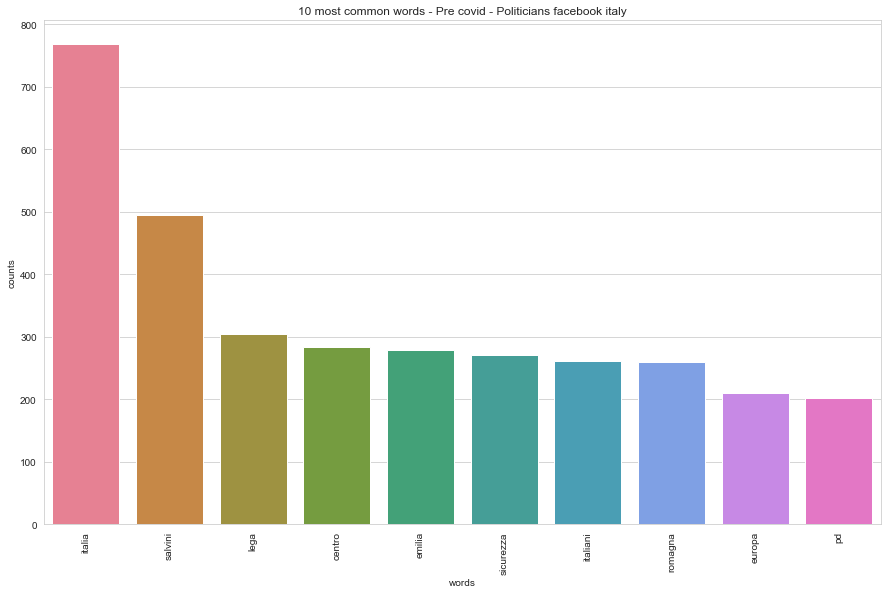

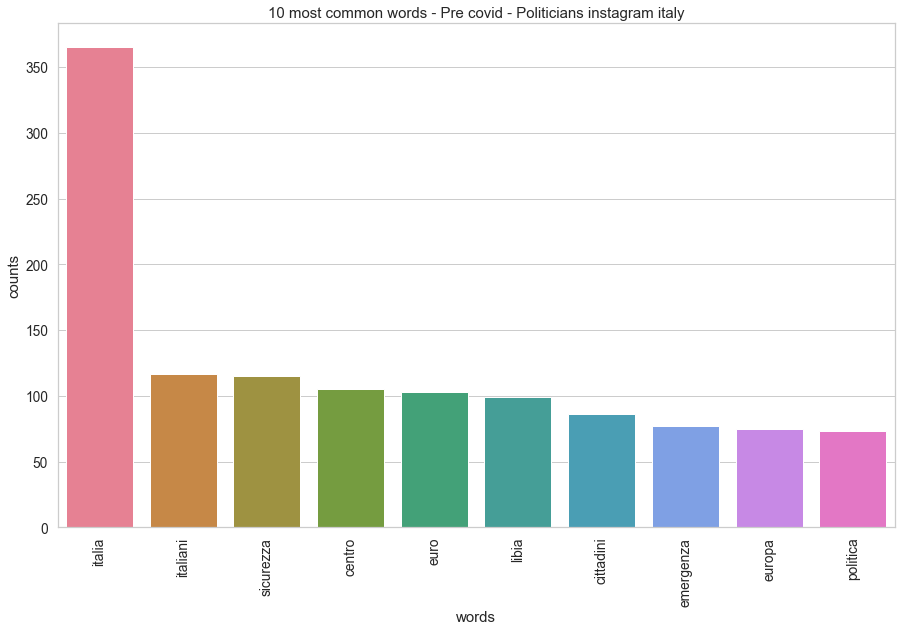

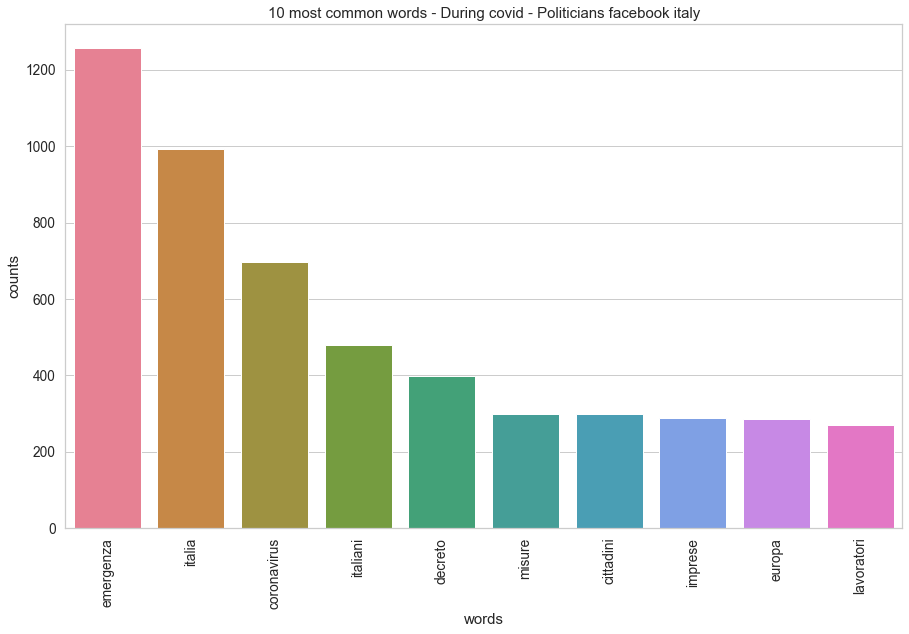

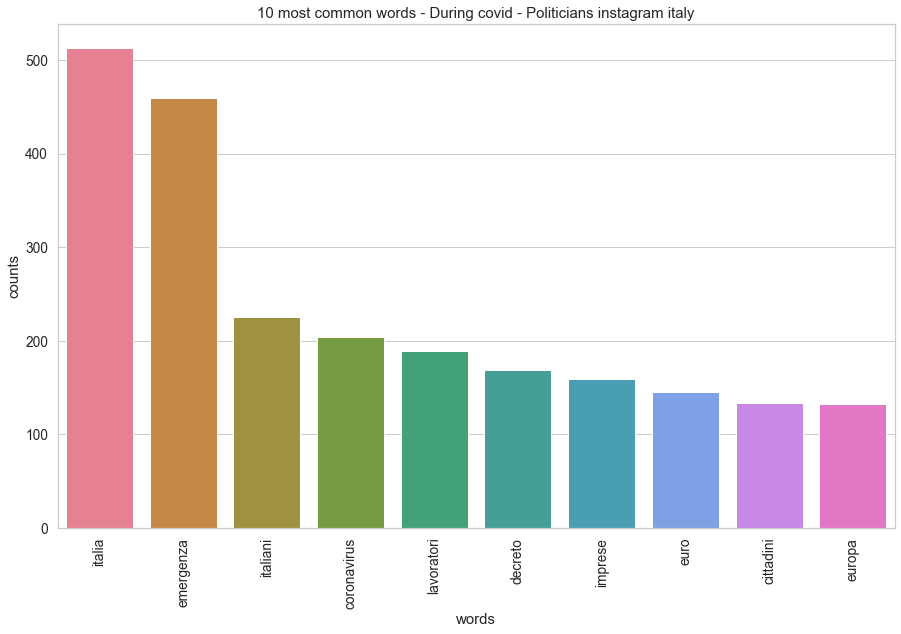

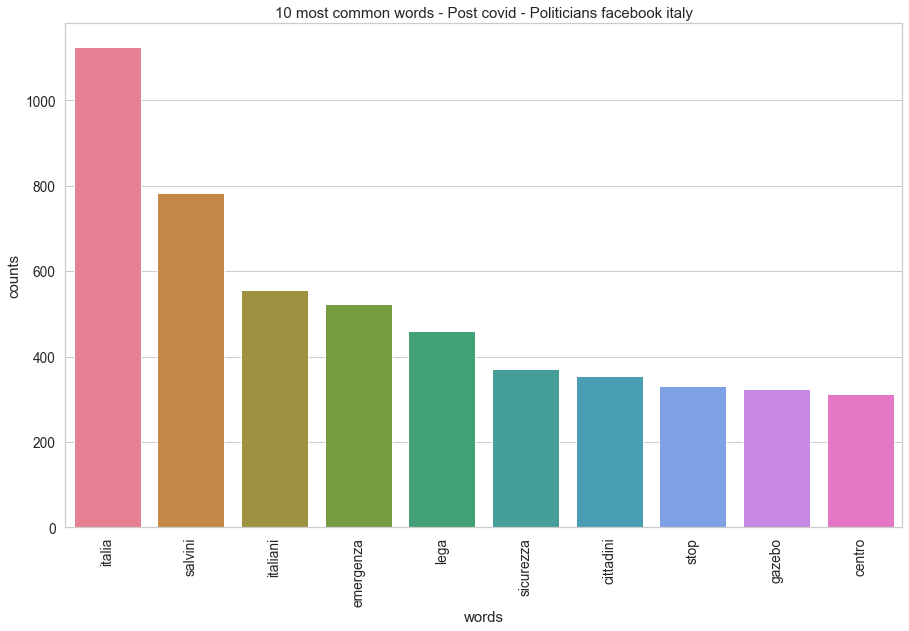

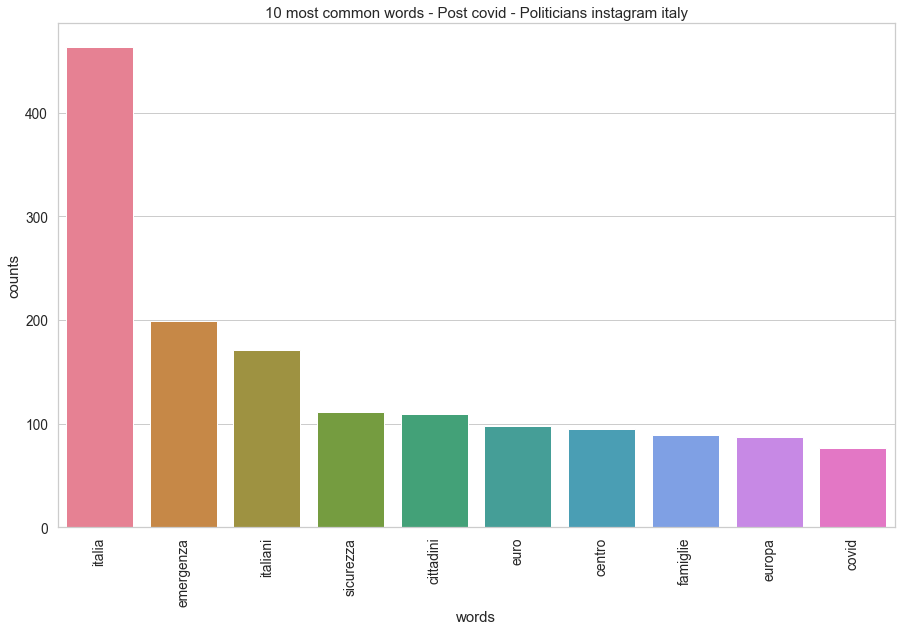

In [22]:
for phase, dicts in df_covid_phase_map.items():
    for name, df in dicts.items():
        if name.split("_")[0] == "politicians":
            count_vectorizer = CountVectorizer(stop_words=all_stopwords)
            if name.split("_")[1] == "instagram":
                vectorized_data_map[phase][name] = count_vectorizer.fit_transform(
                    df["Description"]
                )
            else:
                vectorized_data_map[phase][name] = count_vectorizer.fit_transform(
                    df["Message"]
                )
            count_vectorizer_map[phase][name] = count_vectorizer
            del count_vectorizer
            gc.collect()
            plot_10_most_common_words(
                vectorized_data_map[phase][name],
                count_vectorizer_map[phase][name],
                phase,
                name,
            )

### Create and fit the LDA model

In [23]:
# import warnings

# warnings.simplefilter("ignore", DeprecationWarning)
# Load the LDA model from sk-learn
from sklearn.decomposition import LatentDirichletAllocation as LDA

# Helper function
def print_topics(model, count_vectorizer, n_top_words):
    words = count_vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(len(topic))
        print(" ".join([words[i] for i in topic.argsort()[: -n_top_words - 1 : -1]]))


# Tweak the two parameters below
number_topics = 8
number_words = 6

for phase, dicts in vectorized_data_map.items():
    for name, df in dicts.items():
        lda = LDA(n_components=number_topics, n_jobs=-1)
        lda.fit_transform(df)
        lda_map[phase][name] = lda
        del lda
        gc.collect()
        # Print the topics found by the LDA model
        # print("Topics found via LDA:")
        # print_topics(
        #    lda_map[phase][name], count_vectorizer_map[phase][name], number_words
        # )

In [ ]:
%%time
from pyLDAvis import sklearn as sklearn_lda
import pickle 
import pyLDAvis
import os

for phase, dicts in vectorized_data_map.items():
    for name, df in dicts.items():
        if name.split("_")[0] == "politicians":
            LDAvis_data_filepath = 'Output/lda/ldavis_{}_{}_{}_{}.pickle'.format(phase,name,number_topics, number_words)
            LDAvis_prepared = sklearn_lda.prepare(lda_map[phase][name], df, count_vectorizer_map[phase][name])
            with open(LDAvis_data_filepath, 'wb') as f:
                pickle.dump(LDAvis_prepared, f)
            pyLDAvis.save_html(LDAvis_prepared,'Output/lda/ldavis_{}_{}_{}_{}.html'.format(phase,name,number_topics, number_words))
    
# load the pre-prepared pyLDAvis data from disk
#with open(LDAvis_data_filepath) as f:
#    LDAvis_prepared = pickle.load(f)